## Calc de gradient vector for a cavity. 

# Ahora voy a probar con un desplazamiento negativo y otro positivo, p/ calcular la derivada con estos 2 puntos y así obtener la derivada p/ el punto central (la struct average)

In [25]:
using DataFrames
using Gadfly
using Cairo
using Distributions
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

In [26]:
function meta_var(s::AbstractString, v::Any)
         s=symbol(s) 
         @eval (($s) = ($v))
end

meta_var (generic function with 1 method)

In [27]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [28]:
function read_ptraj_modes(file, modes_to_read = 0)    
    # Read file
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)
    # Determine number of modes to store
    if (modes_to_read == 0)
        # Read all modes
        nmodes = modes_text[1, 5]
    else
        nmodes = modes_to_read
    end
    # Determine number of elements of each mode
    ncoords = convert(Int64, modes_text[2, 1])
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));
    # +2 to skip the header and +1 to read next line.
    j = lines + 1 + 2 

    # Store modes
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end
    # Normalize each mode
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 2 methods)

In [29]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

# Gradiente en base de modos de PCA

### Preparo variables y leo archivos de pdb y modos.

In [30]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
pdb_name = "mtn"
filename_pdb_file_original = string("/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/bu/cut_avg_", pdb_name, ".pdb")
mtn_pdb = read(filename_pdb_file_original, PDBFile, group="ATOM");
# Get the atom count
natoms = length(atoms(mtn_pdb, "*", "*", "ATOM", "*", "*"))
# Obtengo el número de átomos de c/ residuo
for i=1:length(mtn_pdb)
    push!(natom_res, length(mtn_pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's
aa = length(mtn_pdb)
aa3 = aa * 3

# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_1 = Array{Float64}(aa3-6);
vol_pocket_mtn_2 = Array{Float64}(aa3-6);
vol_pocket_mtn_3 = Array{Float64}(aa3-6);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_mtn, evals_mtn = read_ptraj_modes("/home/german/labo/16/hemo/run/mtn/pca/all_atom_modes_mtn", 315);
# OXT is not considered
modes_mtn = modes_mtn[1:end-3, :]
evals_mtn = evals_mtn[1:end-3, :]
# Prepare variebles. 
nonH_natoms3 = length(modes_mtn[:, 1])
nonH_natoms = convert(Int64, nonH_natoms3/3)
modo_sum = Array{Float64}(nonH_natoms, 3);
all_atoms_arr = atoms(mtn_pdb, "*", "*", "ATOM", "*", "*")
non_H_atoms_arr = atoms(mtn_pdb, "*", "*", "ATOM", "*", r"^[^H]")

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/mtn/"
# Archivos de config de ANA
conf_mtn_corto = "/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/bu/mtn_corto.cfg"
conf_mtn_portal = "/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/bu/mtn_portal.cfg"
conf_mtn_largo = "/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/bu/mtn_largo.cfg"

"/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/bu/mtn_largo.cfg"

### Desplazo la estructura original a lo largo de cada modo. Los modos son normalizados y luego multiplicados por -2 y 2; y así obtener distintos desplazamientos. Creando así 2 sets, c/u de 315 estructuras desplazadas (1 por c/ modo)

In [31]:
constant = 1
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [-2 2]
    if magnitude >= 0
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    temp_modo_sum = Array{Float64}(natoms, 3)
    for j=1:aa3-6
        for i=1:nonH_natoms
            modo_sum[i, 1] = modes_mtn[i*3-2, j]
            modo_sum[i, 2] = modes_mtn[i*3-1, j]
            modo_sum[i, 3] = modes_mtn[i*3, j]
        end
    # Ya tengo el modo en el formato adecuado, pero estos son p/ mover nonH atoms. Now, I have to assing
    # displacement coordinates for the H atoms.
        cont = 1
        for i=1:natoms
            if all_atoms_arr[i] == non_H_atoms_arr[cont]
                temp_modo_sum[i, :] = modo_sum[cont, :]
                cont = cont + 1    
            else
                # If this atom is a H, move it in the same direction of the last nonH atom
                temp_modo_sum[i, :] = modo_sum[cont-1, :]
            end
        end
# Ajusto el desplazamiento q voy a hacer
        factor = magnitude * constant 
# Modifico las coordenadas
        mtn_atom_xyz = coordinatesmatrix(mtn_pdb)
        new_mtn_atom_xyz = mtn_atom_xyz + temp_modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
        new_mtn_pdb = change_coordinates(mtn_pdb, new_mtn_atom_xyz)
# Escribo el nuevo .pdb
        pdb_mtn = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mtn.pdb")
        write(pdb_mtn, new_mtn_pdb, PDBFile)
    end
end

### Ahora calculo los volumenes de los huecos corto, portal y largo p/ los 2 sets de 315 estructuras desplazadas. Y así junto 2 sets (1 por c/ magnitud de desplazamiento) de 3 vectores (1 por c/ hueco) de 315 elementos c/u (1 elemento -> 1 volumen de 1 hueco de 1 estructura desplazada en alguna de sus coordenadas x,y,z)
### Luego le resto los volumenes originales de los huecos corto, portal y largo a c/u de los elementos de los 6 vectores y así obtengo 2 sets de 3 vectores gradiente en base de coordenadas cartesianas.

In [32]:
# Ahora calculo los vectores
for magnitude in [-2; 2]
#magnitude = -1
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    # Meta?
    global vec_gdte_corto = symbol("gdte_corto_", displacement)
    global vec_gdte_portal = symbol("gdte_portal_", displacement)
    global vec_gdte_largo = symbol("gdte_largo_", displacement)
    
    out_gdte_corto = string("gdte_corto_", magnitude)
    out_gdte_portal = string("gdte_portal_", magnitude)
    out_gdte_largo = string("gdte_largo_", magnitude)    
    for j=1:aa3-6
        pdb_mtn = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mtn.pdb")
    # Calculo el pocket        
        vol_pocket_mtn_1[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_corto`))
        vol_pocket_mtn_2[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_portal`))
        vol_pocket_mtn_3[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_largo`))
    end

    # Calculo el pocket original
    pdb_mtn = "/home/german/labo/16/hemo/cavities/newana_mode_gradient/bu/cut_avg_mtn.pdb"    
    orig_vol_pocket_mtn_1 = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_corto`))
    orig_vol_pocket_mtn_2 = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_portal`))
    orig_vol_pocket_mtn_3 = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_largo`))
        
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mtn_1 = (vol_pocket_mtn_1 .- orig_vol_pocket_mtn_1)
    vec_pocket_mtn_2 = (vol_pocket_mtn_2 .- orig_vol_pocket_mtn_2)
    vec_pocket_mtn_3 = (vol_pocket_mtn_3 .- orig_vol_pocket_mtn_3)
    # Los normalizo
    vec_pocket_mtn_1 = vec_pocket_mtn_1 / norm(vec_pocket_mtn_1)
    vec_pocket_mtn_2 = vec_pocket_mtn_2 / norm(vec_pocket_mtn_2)
    vec_pocket_mtn_3 = vec_pocket_mtn_3 / norm(vec_pocket_mtn_3)
    
    # Los guardo
    filename_out_gdte_corto = string("/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/vtores/", magnitude,"_vec_pocket_mtn_corto")
    filename_out_gdte_portal = string("/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/vtores/", magnitude,"_vec_pocket_mtn_portal")
    filename_out_gdte_largo = string("/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/vtores/", magnitude,"_vec_pocket_mtn_largo")    
    #
    df_gdte_corto = DataFrame(delta = vec_pocket_mtn_1)
    df_gdte_portal = DataFrame(delta = vec_pocket_mtn_2)
    df_gdte_largo = DataFrame(delta = vec_pocket_mtn_3)
    #
    writetable(filename_out_gdte_corto, df_gdte_corto)
    writetable(filename_out_gdte_portal, df_gdte_portal)
    writetable(filename_out_gdte_largo, df_gdte_largo);
    
    # Meta?
    @eval ($vec_gdte_corto = $vec_pocket_mtn_1)
    @eval ($vec_gdte_portal = $vec_pocket_mtn_2)
    @eval ($vec_gdte_largo = $vec_pocket_mtn_3)            
end

### Ahora hago lo mismo, pero en vez de hacerlo entre [-2; 0] y [0; 2] lo voy a hacer entre [-2; 2]

In [33]:
# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_1_ = Array{Float64}(aa3-6);
vol_pocket_mtn_2_ = Array{Float64}(aa3-6);
vol_pocket_mtn_3_ = Array{Float64}(aa3-6);

# Ahora calculo los vectores
magnitude_ = -2
magnitude = 2
displacement_ = string("d_", magnitude)
displacement = string("d", magnitude)
ddisplacement = string("dd", magnitude)
# Meta?
global vec_gdte_corto = symbol("gdte_corto_", ddisplacement)
global vec_gdte_portal = symbol("gdte_portal_", ddisplacement)
global vec_gdte_largo = symbol("gdte_largo_", ddisplacement)
    
out_gdte_corto = string("gdte_corto_", magnitude)
out_gdte_portal = string("gdte_portal_", magnitude)
out_gdte_largo = string("gdte_largo_", magnitude)   

for j=1:aa3-6
    pdb_mtn = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mtn.pdb")
# Calculo el pocket        
    vol_pocket_mtn_1[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_corto`))
    vol_pocket_mtn_2[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_portal`))
    vol_pocket_mtn_3[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_largo`))
end
for j=1:aa3-6
    pdb_mtn = string(files_template, displacement_, "/", "mod", j, "_", displacement_, "_mtn.pdb")
# Calculo el pocket        
    vol_pocket_mtn_1_[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_corto`))
    vol_pocket_mtn_2_[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_portal`))
    vol_pocket_mtn_3_[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_largo`))
end
     
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mtn_1 = (vol_pocket_mtn_1 - vol_pocket_mtn_1_)
    vec_pocket_mtn_2 = (vol_pocket_mtn_2 - vol_pocket_mtn_2_)
    vec_pocket_mtn_3 = (vol_pocket_mtn_3 - vol_pocket_mtn_3_)
    # Los normalizo
    vec_pocket_mtn_1 = vec_pocket_mtn_1 / norm(vec_pocket_mtn_1)
    vec_pocket_mtn_2 = vec_pocket_mtn_2 / norm(vec_pocket_mtn_2)
    vec_pocket_mtn_3 = vec_pocket_mtn_3 / norm(vec_pocket_mtn_3)
    
    # Los guardo
    filename_out_gdte_corto = string("/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/vtores/", ddisplacement,"_vec_pocket_mtn_corto")
    filename_out_gdte_portal = string("/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/vtores/", ddisplacement,"_vec_pocket_mtn_portal")
    filename_out_gdte_largo = string("/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/vtores/", ddisplacement,"_vec_pocket_mtn_largo")    
    #
    df_gdte_corto = DataFrame(delta = vec_pocket_mtn_1)
    df_gdte_portal = DataFrame(delta = vec_pocket_mtn_2)
    df_gdte_largo = DataFrame(delta = vec_pocket_mtn_3)
    #
    writetable(filename_out_gdte_corto, df_gdte_corto)
    writetable(filename_out_gdte_portal, df_gdte_portal)
    writetable(filename_out_gdte_largo, df_gdte_largo);
    
    # Meta?
    @eval ($vec_gdte_corto = $vec_pocket_mtn_1)
    @eval ($vec_gdte_portal = $vec_pocket_mtn_2)
    @eval ($vec_gdte_largo = $vec_pocket_mtn_3);      

## Grafico los vectores. El eje 'x' es el nro de elemento y el 'y' el valor del elemento.

### Canal corto

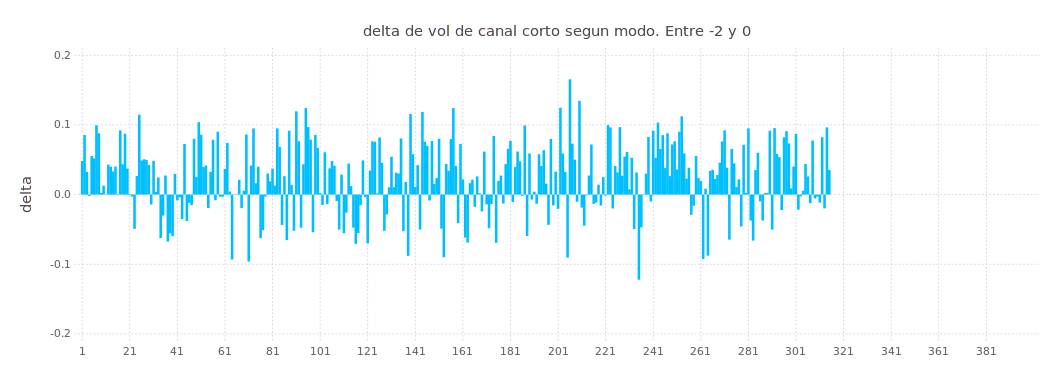

In [34]:
df_gdte_corto = DataFrame(delta = gdte_corto_d_2)
pdf_gdte_corto = plot(df_gdte_corto,
y="delta",  
Geom.bar(position=:dodge),
Guide.Title("delta de vol de canal corto segun modo. Entre -2 y 0"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

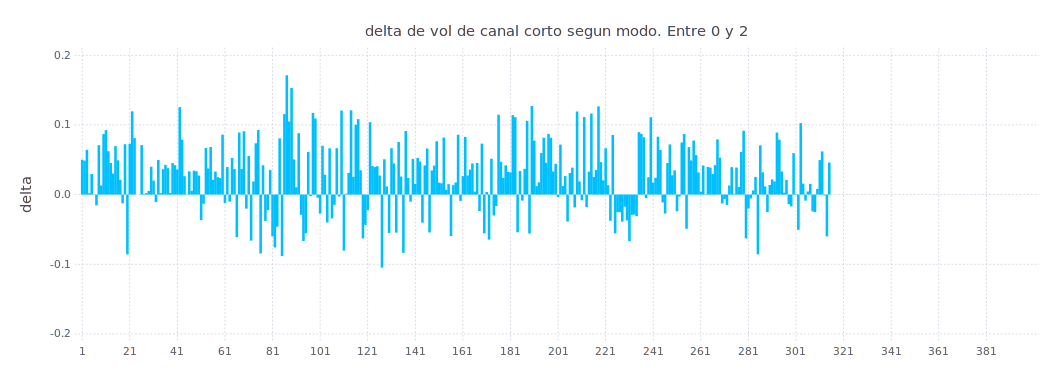

In [35]:
df_gdte_corto = DataFrame(delta = gdte_corto_d2)
pdf_gdte_corto = plot(df_gdte_corto,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun modo. Entre 0 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

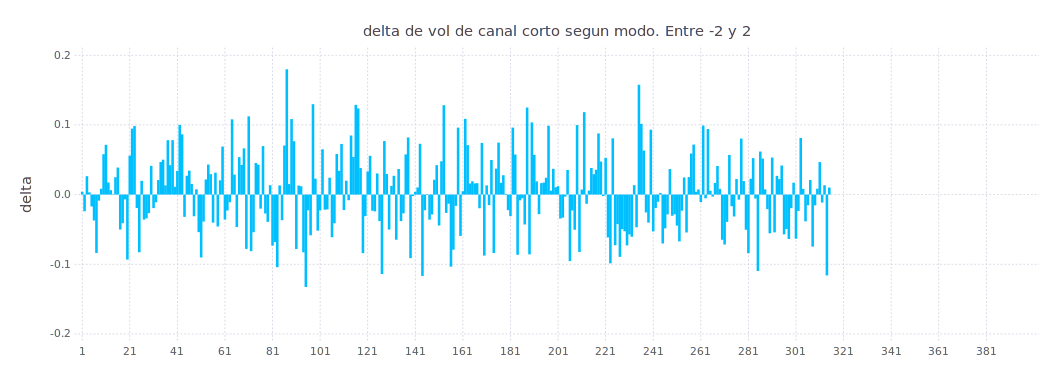

In [36]:
df_gdte_corto = DataFrame(delta = gdte_corto_dd2)
pdf_gdte_corto = plot(df_gdte_corto,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun modo. Entre -2 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Comparo los vectores obtenidos entre [-2;0] [0;2] [-2;2]

In [37]:
dot(gdte_corto_d2, gdte_corto_d_2) 

0.1078612103669378

In [38]:
dot(gdte_corto_dd2, gdte_corto_d_2)

-0.6383011176204823

In [39]:
dot(gdte_corto_d2, gdte_corto_dd2)

0.6964478810696413

### Canal portal

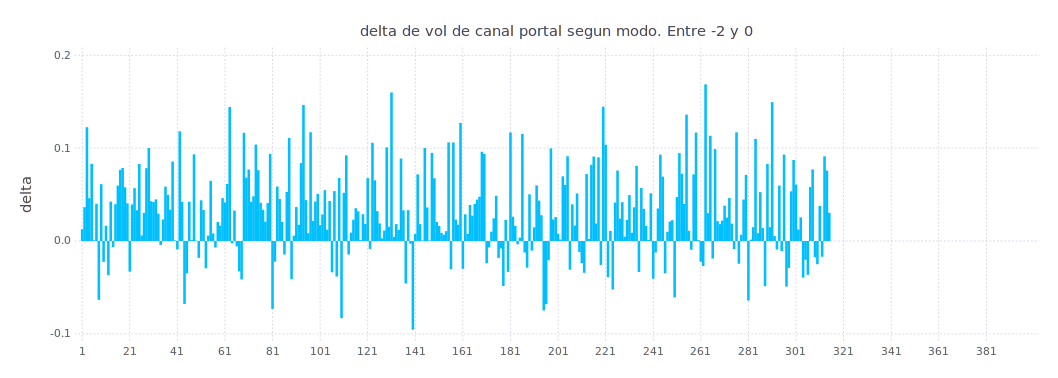

In [40]:
df_gdte_portal = DataFrame(delta = gdte_portal_d_2)
pdf_gdte_portal = plot(df_gdte_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal portal segun modo. Entre -2 y 0"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

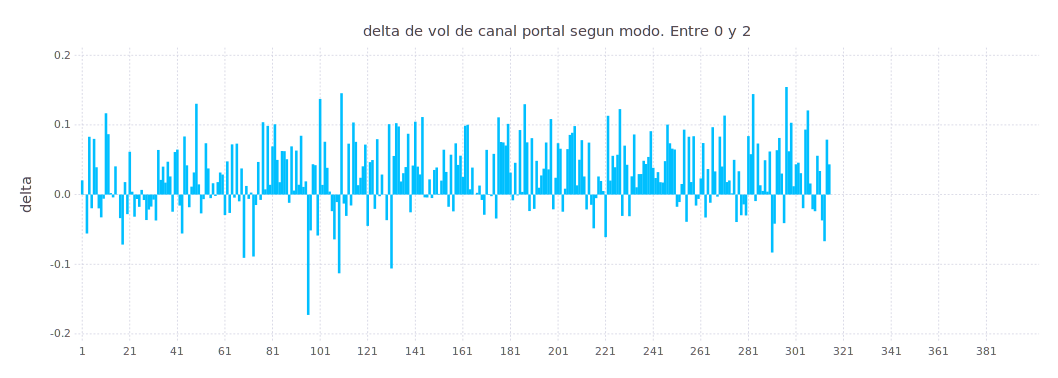

In [41]:
df_gdte_portal = DataFrame(delta = gdte_portal_d2)
pdf_gdte_portal = plot(df_gdte_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal portal segun modo. Entre 0 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

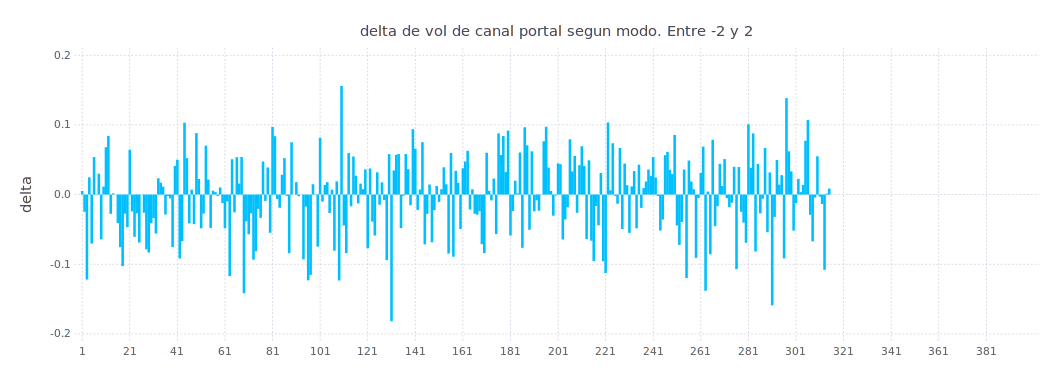

In [42]:
df_gdte_portal = DataFrame(delta = gdte_portal_dd2)
pdf_gdte_portal = plot(df_gdte_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal portal segun modo. Entre -2 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Comparo los vectores obtenidos entre [-2;0] [0;2] [-2;2]

In [43]:
dot(gdte_portal_d2, gdte_portal_d_2)

-0.07272039988792844

In [44]:
dot(gdte_portal_dd2, gdte_portal_d_2)

-0.7356087228812599

In [45]:
dot(gdte_portal_d2, gdte_portal_dd2)

0.7291069136116708

### Canal largo

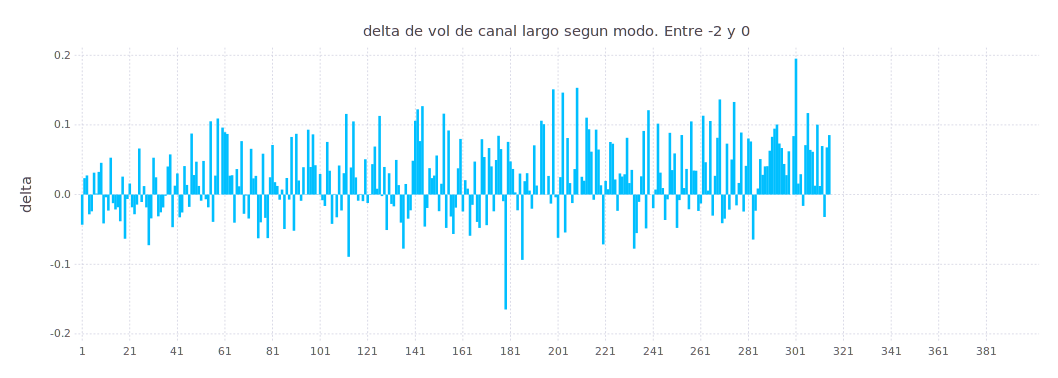

In [46]:
df_gdte_largo = DataFrame(delta = gdte_largo_d_2)
pdf_gdte_largo = plot(df_gdte_largo,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo. Entre -2 y 0"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

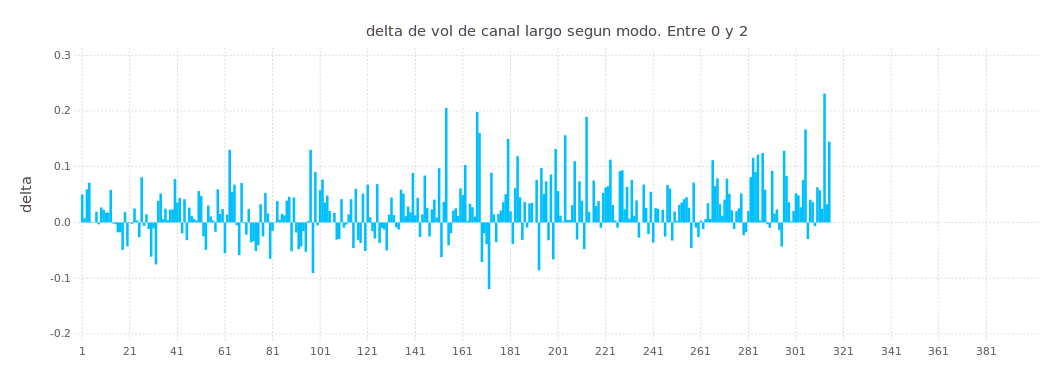

In [47]:
df_gdte_largo = DataFrame(delta = gdte_largo_d2)
pdf_gdte_largo = plot(df_gdte_largo,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo. Entre 0 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

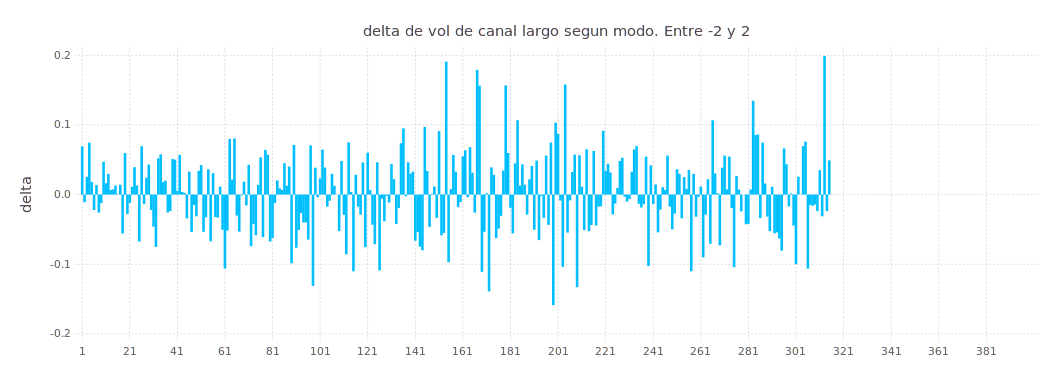

In [48]:
df_gdte_largo = DataFrame(delta = gdte_largo_dd2)
pdf_gdte_largo = plot(df_gdte_largo,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo. Entre -2 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Comparo los vectores obtenidos entre [-2;0] [0;2] [-2;2]

In [49]:
dot(gdte_largo_d2, gdte_largo_d_2)

0.08428967771697154

In [50]:
dot(gdte_largo_dd2, gdte_largo_d_2)

-0.6521164067126252

In [51]:
dot(gdte_largo_d2, gdte_largo_dd2)

0.7004542462240165

### Guardo los 3 gráficos en 1 pdf

In [52]:
magnitude = 2
displacement = string("dd", magnitude)
out_filename_pdf_gdte_corto = string("/home/german/labo/16/hemo/rtdos_log/all_atom_newana_", displacement,"_corto_mtn.pdf")
out_filename_pdf_gdte_portal = string("/home/german/labo/16/hemo/rtdos_log/all_atom_newana_", displacement,"_portal_mtn.pdf")
out_filename_pdf_gdte_largo = string("/home/german/labo/16/hemo/rtdos_log/all_atom_newana_", displacement,"_largo_mtn.pdf")
out_filename_pdf_gdtes = string("/home/german/labo/16/hemo/rtdos_log/all_atom_newana_", displacement,"_mtn.pdf")
# Guardo los plots
draw(PDF(out_filename_pdf_gdte_corto, 20cm, 10cm), pdf_gdte_corto)
draw(PDF(out_filename_pdf_gdte_portal, 20cm, 10cm), pdf_gdte_portal)
draw(PDF(out_filename_pdf_gdte_largo, 20cm, 10cm), pdf_gdte_largo)
run(`pdftk $out_filename_pdf_gdte_corto $out_filename_pdf_gdte_portal $out_filename_pdf_gdte_largo output $out_filename_pdf_gdtes`)
run(`rm $out_filename_pdf_gdte_corto`)
run(`rm $out_filename_pdf_gdte_portal`)
run(`rm $out_filename_pdf_gdte_largo`)

# Gradiente de 1 solo pocket en base de modos de PCA

### Preparo variables 

In [53]:
# Arrays p/ guardar volumenes de pockets
vol_pocket_mtn_whole = Array{Float64}(aa3-6);
vol_pocket_mtn_whole_ = Array{Float64}(aa3-6);

# Archivos de config de ANA
conf_mtn_whole = "/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/bu/mtn_whole.cfg"

"/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/bu/mtn_whole.cfg"

In [54]:
# Ahora calculo los vectores
for magnitude in [-2; 2]
    if magnitude >= 0
        magnitude_ = magnitude
        displacement = string("d", magnitude_)
    else
        magnitude_ = magnitude * -1
        displacement = string("d_", magnitude_)
    end
    
    # Meta?
    global vec_gdte_whole = symbol("gdte_whole_", displacement)
    
    out_gdte_corto = string("gdte_whole_", magnitude)
    for j=1:aa3-6
        pdb_mtn = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mtn.pdb")
    # Calculo el pocket        
        vol_pocket_mtn_whole[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole`))
    end

    # Calculo el pocket original
    pdb_mtn = "/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/bu/cut_avg_mtn.pdb"    
    orig_vol_pocket_mtn_whole = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole`))
        
    # Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
    vec_pocket_mtn_whole = (vol_pocket_mtn_whole .- orig_vol_pocket_mtn_whole)
    # Los normalizo
    vec_pocket_mtn_whole = vec_pocket_mtn_whole / norm(vec_pocket_mtn_whole)
    
    # Los guardo
    filename_out_gdte_whole = string("/home/german/labo/16/hemo/cavities/all_atom_newana_mode_gradient/vtores/", magnitude,"_vec_pocket_mtn_whole")  
    #
    df_gdte_whole = DataFrame(delta = vec_pocket_mtn_whole)
    #
    writetable(filename_out_gdte_whole, df_gdte_whole)
    
    # Meta?
    @eval ($vec_gdte_whole = $vec_pocket_mtn_whole)           
end

In [55]:
# Ahora calculo los vectores
magnitude_ = -2
magnitude = 2
displacement_ = string("d_", magnitude)
displacement = string("d", magnitude)
ddisplacement = string("dd", magnitude)
# Meta?
global vec_gdte_whole = symbol("gdte_whole_", ddisplacement)
    
out_gdte_whole = string("gdte_whole_", magnitude) 
for j=1:aa3-6
    pdb_mtn = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mtn.pdb")
# Calculo el pocket        
    vol_pocket_mtn_whole[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole`))
end
for j=1:aa3-6
    pdb_mtn = string(files_template, displacement_, "/", "mod", j, "_", displacement_, "_mtn.pdb")
# Calculo el pocket        
    vol_pocket_mtn_whole_[j] = parse(Float64, readall(`ANA $pdb_mtn -c $conf_mtn_whole`))    
end
     
# Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
vec_pocket_mtn_whole = (vol_pocket_mtn_whole - vol_pocket_mtn_whole_)
# Los normalizo
vec_pocket_mtn_whole = vec_pocket_mtn_whole / norm(vec_pocket_mtn_whole)

# Los guardo
filename_out_gdte_whole = string("/home/german/labo/16/hemo/cavities/newana_mode_gradient/vtores/", ddisplacement,"_vec_pocket_mtn_whole")  
#
df_gdte_whole = DataFrame(delta = vec_pocket_mtn_whole)
#
writetable(filename_out_gdte_whole, df_gdte_whole)
    
# Meta?
@eval ($vec_gdte_whole = $vec_pocket_mtn_whole);

### Grafico los vectores. El eje 'x' es el nro de elemento y el 'y' el valor del elemento.

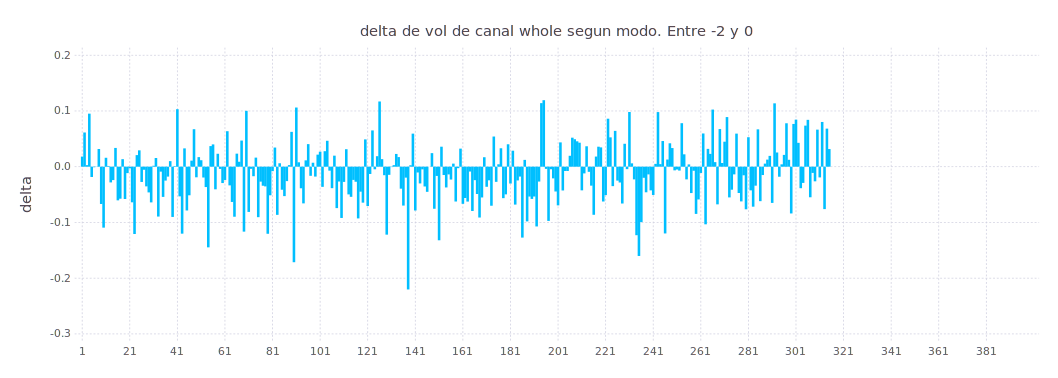

In [56]:
df_gdte_corto = DataFrame(delta = gdte_whole_d_2)
pdf_gdte_corto = plot(df_gdte_corto,
y="delta",  
Geom.bar(position=:dodge),
Guide.Title("delta de vol de canal whole segun modo. Entre -2 y 0"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

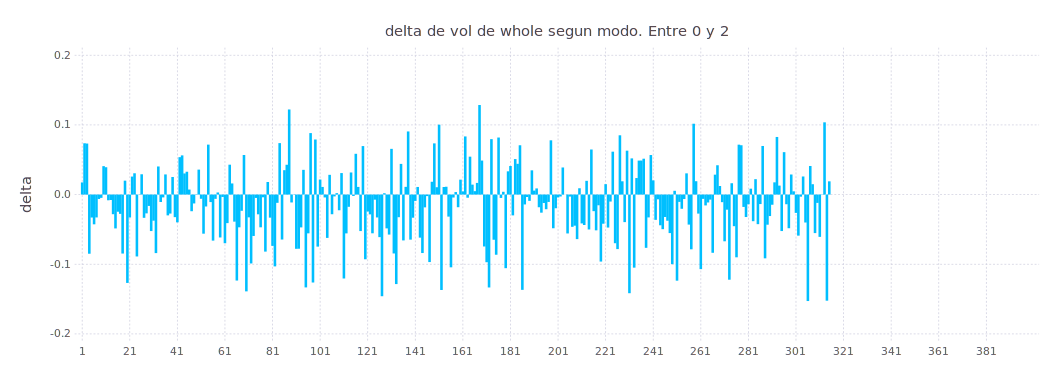

In [57]:
df_gdte_portal = DataFrame(delta = gdte_whole_d2)
pdf_gdte_portal = plot(df_gdte_portal,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de whole segun modo. Entre 0 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

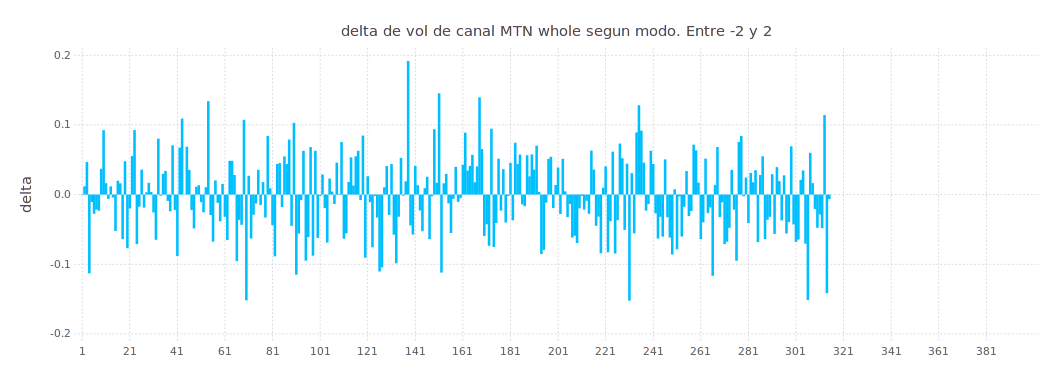

In [58]:
df_gdte_whole = DataFrame(delta = gdte_whole_dd2)
pdf_gdte_whole = plot(df_gdte_whole,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal MTN whole segun modo. Entre -2 y 2"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:20:400), orientation=:horizontal))

### Comparo los vectores obtenidos entre [-2;0] [0;2] [-2;2]

In [59]:
dot(gdte_whole_d2, gdte_whole_d_2)

-0.25846344173967895

In [60]:
dot(gdte_whole_dd2, gdte_whole_d_2)

-0.7696240078741541

In [61]:
dot(gdte_whole_d2, gdte_whole_dd2)

0.8157215594031054

### Guardo el gráfico en 1 pdf

In [62]:
magnitude = 2
displacement = string("dd", magnitude)
out_filename_pdf_gdte_whole = string("/home/german/labo/16/hemo/rtdos_log/all_atom_newana_", displacement,"whole_mtn.pdf")
# Guardo el plot
draw(PDF(out_filename_pdf_gdte_whole, 20cm, 10cm), pdf_gdte_whole)